# track plot

In [ ]:
grep -e "ENST00000409052" gencode.v44.annotation.gtf > IL1RN_tail.gtf    

In [ ]:
#!/bin/bash


make_tracks_file --trackFiles /mnt/ruiyanhou/nfs_share2/annotation/annotation_from_Gencode/IL1RN_tail.gtf  \
        /mnt/ruiyanhou/nfs_share2/three_primer/ESCC/run_sinto/celltype_sample_subbam_reads2/Endothelial_cells_Normal.bw \
        /mnt/ruiyanhou/nfs_share2/three_primer/ESCC/run_sinto/celltype_sample_subbam_reads2/Endothelial_cells_Tumor.bw \
        /mnt/ruiyanhou/nfs_share2/three_primer/ESCC/run_sinto/celltype_sample_subbam_reads2/T_cells_Normal.bw \
        /mnt/ruiyanhou/nfs_share2/three_primer/ESCC/run_sinto/celltype_sample_subbam_reads2/T_cells_Tumor.bw \
        /mnt/ruiyanhou/nfs_share2/three_primer/ESCC/run_sinto/celltype_sample_subbam_reads2/Cycling_cells_Normal.bw \
        /mnt/ruiyanhou/nfs_share2/three_primer/ESCC/run_sinto/celltype_sample_subbam_reads2/Cycling_cells_Tumor.bw \
        /mnt/ruiyanhou/nfs_share2/three_primer/ESCC/run_sinto/celltype_sample_subbam_reads2/B_cells_Normal.bw \
       /mnt/ruiyanhou/nfs_share2/three_primer/ESCC/run_sinto/celltype_sample_subbam_reads2/B_cells_Tumor.bw \
        -o mainfigure_AHNAK_tracks.ini

In [ ]:
pyGenomeTracks --tracks mainfigure_IL1RN_tracks.ini --fontSize 18 --dpi 300 --width 54  --region chr2:113098315-113135016  --outFileName IL1RN_final.pdf

# Violin plot

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import scanpy as sc
from functools import reduce

In [2]:
adata=sc.read('/mnt/ruiyanhou/nfs_share2/three_primer/ESCC/ERCC_part/ERCC_PAS_exp.h5ad')
adata

/mnt/ruiyanhou/nfs_share2/conda_env/envs/Py39/lib/python3.9/site-packages/anndata-0.10.3-py3.9.egg/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 89313 × 9888
    obs: 'patient', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.2.6', 'seurat_clusters', 'SampleType', 'PatientType', 'celltype'
    var: 'cluster_start', 'cluster_end', 'cluster_score', 'cluster_strand', 'gene_start', 'gene_end', 'gene_score', 'gene_strand', 'cluster_chr', 'gene_chr', 'gene_id', 'gene_name', 'new_cluster_id'
    uns: 'PatientType_colors', 'SampleType_colors', 'celltype_colors'
    obsm: 'X_umap'

In [3]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [4]:
sc.pp.log1p(adata)

In [5]:
adata.var['new_cluster_name']=adata.var['cluster_chr'].astype('str')+'_'+adata.var['cluster_start'].astype('str')+'_'+adata.var['cluster_end'].astype('str')
adata

AnnData object with n_obs × n_vars = 89313 × 9888
    obs: 'patient', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.2.6', 'seurat_clusters', 'SampleType', 'PatientType', 'celltype'
    var: 'cluster_start', 'cluster_end', 'cluster_score', 'cluster_strand', 'gene_start', 'gene_end', 'gene_score', 'gene_strand', 'cluster_chr', 'gene_chr', 'gene_id', 'gene_name', 'new_cluster_id', 'new_cluster_name'
    uns: 'PatientType_colors', 'SampleType_colors', 'celltype_colors', 'log1p'
    obsm: 'X_umap'

In [6]:
adata.var['original_cluster_id']=adata.var.index
adata

AnnData object with n_obs × n_vars = 89313 × 9888
    obs: 'patient', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.2.6', 'seurat_clusters', 'SampleType', 'PatientType', 'celltype'
    var: 'cluster_start', 'cluster_end', 'cluster_score', 'cluster_strand', 'gene_start', 'gene_end', 'gene_score', 'gene_strand', 'cluster_chr', 'gene_chr', 'gene_id', 'gene_name', 'new_cluster_id', 'new_cluster_name', 'original_cluster_id'
    uns: 'PatientType_colors', 'SampleType_colors', 'celltype_colors', 'log1p'
    obsm: 'X_umap'

In [7]:
adata.obs['celltype'].unique()

['Fibroblasts', 'Myeloid cells', 'T cells', 'B cells', 'Plasma cells', ..., 'Endothelial cells', 'Cycling cells', 'Mast cells', 'Smooth muscle cells', 'pDC']
Length: 11
Categories (11, object): ['B cells', 'Cycling cells', 'Endothelial cells', 'Epithelial cell', ..., 'Plasma cells', 'Smooth muscle cells', 'T cells', 'pDC']

In [8]:
# plot psi
plt.rcParams['font.size'] = 16

In [9]:
def plot_psi(genename,celltype):
    inputfile='/mnt/ruiyanhou/nfs_share2/three_primer/ESCC/ERCC_part/run_BRIE/Brie_out/brie_ERCC_'+celltype+'.h5ad'
    psiadata=sc.read(inputfile)
    certaingene=psiadata[:,psiadata.var['gene_name']==genename]
    #print(psiadata.var.index)
    #print(certaingene)
    genename=certaingene.var['gene_name'].unique().tolist()[0]
    
    nlhadata=certaingene[certaingene.obs['SampleType']=='Normal']
    npcadata=certaingene[certaingene.obs['SampleType']=='Tumor']
    nlhpsidf=pd.DataFrame(nlhadata.layers['Psi'])
    nlhpsidf['condition']='Normal'
    npcpsidf=pd.DataFrame(npcadata.layers['Psi'])
    npcpsidf['condition']='Tumor'
    plotdf=pd.concat([nlhpsidf,npcpsidf],axis=0)
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.violinplot(x='condition',y=0,data=plotdf,palette=['gold','lightseagreen'])
    pvalue=ttest_ind(nlhadata.layers['Psi'].reshape(-1,1),npcadata.layers['Psi'].reshape(-1,1) )[1]
    pvalue_adj=multipletests(pvalue,method='bonferroni')[1][0]
    plt.ylabel('PSI')
    plt.xlabel('')
    title=genename+' ('+celltype+')'
    plt.title(title)
    #outputfile='/mnt/ruiyanhou/nfs_share2/three_primer/ESCC/ERCC_part/run_BRIE/Brie_out/figure/example/'+celltype+'_'+genename+'_violinplot.pdf'
    #fig.savefig(outputfile,dpi=300,bbox_inches='tight')
    plt.show()
    return psiadata
    

/mnt/ruiyanhou/nfs_share2/conda_env/envs/Py39/lib/python3.9/site-packages/anndata-0.10.3-py3.9.egg/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/tmp/ipykernel_455030/3780694310.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='condition',y=0,data=plotdf,palette=['gold','lightseagreen'])


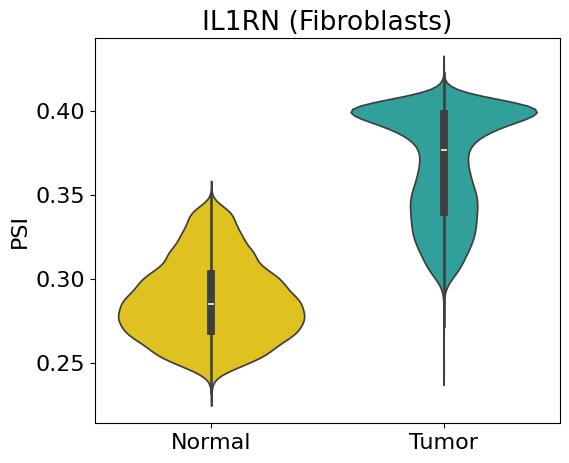

In [10]:
psiadata=plot_psi('IL1RN','Fibroblasts')

/mnt/ruiyanhou/nfs_share2/conda_env/envs/Py39/lib/python3.9/site-packages/anndata-0.10.3-py3.9.egg/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/tmp/ipykernel_455030/3780694310.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='condition',y=0,data=plotdf,palette=['gold','lightseagreen'])


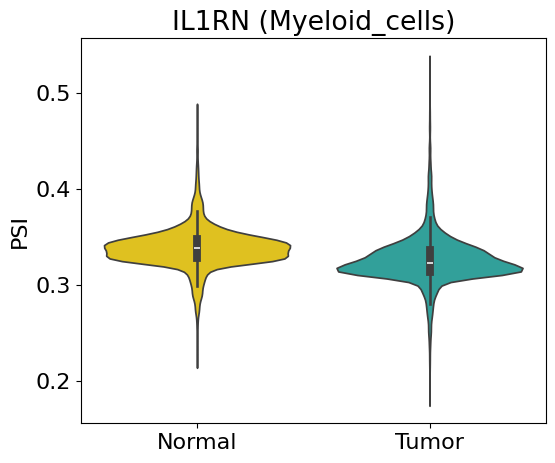

In [11]:
psiadata=plot_psi('IL1RN','Myeloid_cells')

/mnt/ruiyanhou/nfs_share2/conda_env/envs/Py39/lib/python3.9/site-packages/anndata-0.10.3-py3.9.egg/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/tmp/ipykernel_455030/3780694310.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='condition',y=0,data=plotdf,palette=['gold','lightseagreen'])


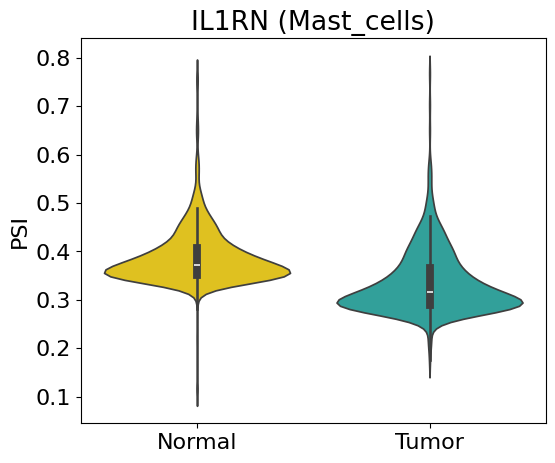

In [12]:
psiadata=plot_psi('IL1RN','Mast_cells')